In [1]:
# imports smh
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"running on device: {device}")
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

running on device: cuda
PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [2]:
# define hyperparameters
batchSize = 32

# loss and optim
learningRate = 0.03
momentum = 0.9

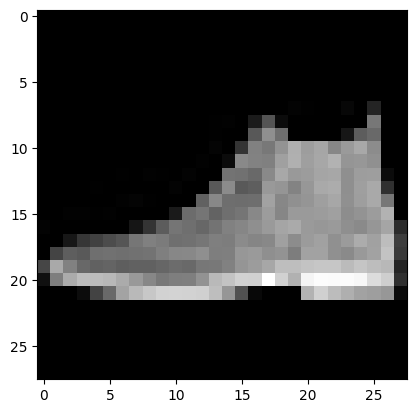

In [3]:
from torch.utils.data import DataLoader

# get data (creates dataset objects)
trainingDataset = datasets.FashionMNIST("data", train = True, download = True, transform = ToTensor())

testDataset = datasets.FashionMNIST("data", train = False, download = True, transform = ToTensor())

# initialize dataloader (passes dataset objects through DataLoader, returns iterable)
trainingData = DataLoader(trainingDataset, batch_size = batchSize, drop_last=True)
testData = DataLoader(testDataset, batch_size = batchSize, drop_last=True)

# data is stored in a list [] of the image as a tensor (index 0), and the label (index 1). (# of each varies on batch size)
# second reference by index [0] is to get first image and label from the batch size of 32
anImage = next(iter(testData))[0][0].squeeze()
aLabel = next(iter(testData))[1][0]
plt.imshow(anImage, cmap="gray")

In [4]:
class Network(nn.Module):
    def __init__(self, inputSize: int, outputSize: int, hidden_sizes=[256, 128, 64]):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], outputSize),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)

# verify things work and im notbrainless
images, labels = next(iter(trainingData))
images.to(device)
images = images.view(batchSize, -1)
print(images.shape)
model = Network(784, len(trainingDataset.classes))
testoutput = model(images.to(device))
testoutput

torch.Size([32, 784])


tensor([[-2.4768, -2.2389, -2.3317, -2.1594, -2.3292, -2.3263, -2.2747, -2.3116,
         -2.2232, -2.3895],
        [-2.4788, -2.2297, -2.3178, -2.1902, -2.3244, -2.3288, -2.2840, -2.2985,
         -2.2395, -2.3629],
        [-2.4735, -2.2138, -2.3314, -2.1904, -2.3265, -2.3266, -2.2764, -2.3033,
         -2.2336, -2.3813],
        [-2.4723, -2.2234, -2.3270, -2.1868, -2.3219, -2.3282, -2.2817, -2.2995,
         -2.2333, -2.3823],
        [-2.4798, -2.2315, -2.3159, -2.1759, -2.3296, -2.3322, -2.2777, -2.2997,
         -2.2378, -2.3776],
        [-2.4709, -2.2214, -2.3283, -2.1879, -2.3286, -2.3381, -2.2852, -2.2982,
         -2.2322, -2.3644],
        [-2.4625, -2.2310, -2.3340, -2.1944, -2.3186, -2.3292, -2.2825, -2.3105,
         -2.2199, -2.3709],
        [-2.4654, -2.2272, -2.3227, -2.1713, -2.3297, -2.3434, -2.2907, -2.3015,
         -2.2393, -2.3647],
        [-2.4767, -2.2235, -2.3407, -2.2002, -2.3276, -2.3212, -2.2797, -2.3005,
         -2.2149, -2.3715],
        [-2.4739, -

In [5]:
from torch.optim.lr_scheduler import *

# define loss and optim functions
lossFunc = nn.NLLLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=learningRate, momentum=momentum)
scheduler1 = StepLR(optimizer=optimizer, step_size=10, gamma=0.2, verbose=True)

# random stuff
images, labels = next(iter(trainingData))
images[0].flatten().shape

Adjusting learning rate of group 0 to 3.0000e-02.


torch.Size([784])

In [6]:
# setup training loop function, define other useful functions & important variables
classNames = trainingDataset.classes

from torchmetrics import Accuracy

def accuracy(prediction, true):
    # convert logits -> probability for accuracy function
    # (check if dimension is 1 (in prediction form already bc im braindead))
    if len(prediction.shape) is not 1:
        prediction = getPredictedValue(prediction)
    return torch.eq(prediction, true).sum().item()/len(prediction)

def train(epochs: int):
    test_acc = 0
    acc = 0
    print(f"Training module {model.__class__.__name__} for {epochs} epochs...")
    model.train()
    for epoch in range(epochs):
        avgLoss = 0
        for imageBatch, labelBatch in trainingData:
            # move tensors to gpu
            imageBatch, labelBatch = imageBatch.to(device), labelBatch.to(device)
            # zero gradients
            optimizer.zero_grad()
            # resize the thing so the thing can be multiplied by the thing (god explanation)
            imageBatch = imageBatch.view(batchSize, -1)
            # pass batch through model
            predictions = model(imageBatch)
            # calculate lsos
            loss = lossFunc(predictions, labelBatch.to(device))
            # back propagapoatation
            loss.backward()
            # update weights and stuff
            optimizer.step()
            # add to total loss & acc (to find avg later)
            avgLoss += loss
            predictions = getPredictedValue(predictions)
            acc += accuracy(predictions, labelBatch)
        else:
            acc /= len(trainingData)
            # validate model with set not used for training
            model.eval()
            with torch.inference_mode():
                for imageBatch, labelBatch in testData:
                    # move tensors to gpu
                    imageBatch, labelBatch = imageBatch.to(device), labelBatch.to(device)
                    test_predictions = model(imageBatch.view(batchSize, -1))
                    test_predictions = getPredictedValue(test_predictions)
                    test_acc += accuracy(test_predictions, labelBatch)
            test_acc /= len(testData)
            avgLoss = avgLoss/len(trainingData)
            # print whats happening
            print(f"Epoch {epoch} || Avg loss per batch: {avgLoss} || Training accuracy: {acc*100:.4f}% ||Test accuracy: {test_acc*100:.4f}%")
        scheduler1.step()
    print("finish.")
    return

# model quick evaluation function
def evalModel(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracyfn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for imageBatch, labelBatch in data_loader:
            # Make predictions with the model
            imageBatch = imageBatch.to(device)
            labelBatch = labelBatch.to(device)
            predictedLabels = model(imageBatch.view(batchSize, -1))

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(predictedLabels, labelBatch)
            acc += accuracyfn(predictedLabels, labelBatch)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


# "Output of the network are log-probabilities, need to take exponential for probabilities"
# - some online tutorial
# I do not understand but will ctrl-c ctrl-v anyway.
# def getPredictedValue(modelOutput: torch.Tensor):
#     ps = torch.exp(modelOutput)
#     probab = list(ps.cpu().detach().numpy()[0])
#     probab = probab.index(max(probab))
#     return probab
# I lied. better way:

def getPredictedValue(modelOutput: torch.Tensor):
    return modelOutput.argmax(dim=1)

# graphs images wtih corresponding labels
def test():
    model.eval()
    # get random data to pass through model

    plt.figure(figsize=(9, 9))
    with torch.inference_mode():
        for i in range(9):
            plt.subplot(3, 3, i+1)
            # get random int within bounds of testDataset
            randInt = torch.randint(high=len(testDataset), size=(1,)).item()
            # get image and label from the tuple at index randInt
            image, label = testDataset[randInt][0], testDataset[randInt][1]
            # get label as the name of predicted class
            label = classNames[label]
            # send image through model for evaluation

            output = model(image.to(device).view(1, -1))
            # get predicted label from output of model
            predictedLabel = getPredictedValue(output)
            predictedLabel = classNames[predictedLabel]
            # show image
            plt.imshow(image.squeeze(), cmap="gray")
            # other plot things
            titleText = f"Pred: {predictedLabel} | Truth: {label}"
            if predictedLabel == label:
                plt.title(titleText, fontsize=10, c="g") # green text if correct
            else:
                plt.title(titleText, fontsize=10, c="r") # red text if wrong
            plt.axis(False);

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\hewit\AppData\Local\Temp\ipykernel_14152\4216302459.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(prediction.shape) is not 1:


Predicted Digit = tensor([3], device='cuda:0')
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
predicted item: Dress
correct item: Dress


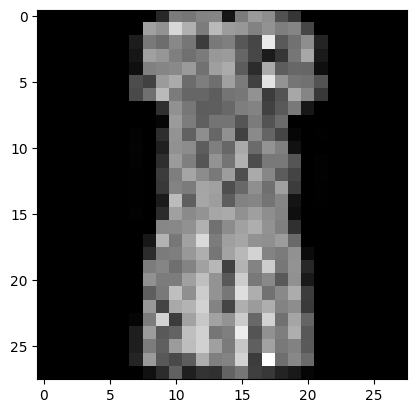

In [7]:
# dont mind this just testing
randInt = torch.randint(high=len(testDataset), size=(1,)).item()
image = testDataset[randInt][0]
label = testDataset[randInt][1]
output = model(image.to(device).view(1, -1))
probab = output.argmax(dim=1)
plt.imshow(image.squeeze(), cmap="gray")
print("Predicted Digit =", probab)
print(classNames)
print(f"predicted item: {classNames[probab]}")
print(f"correct item: {classNames[label]}")

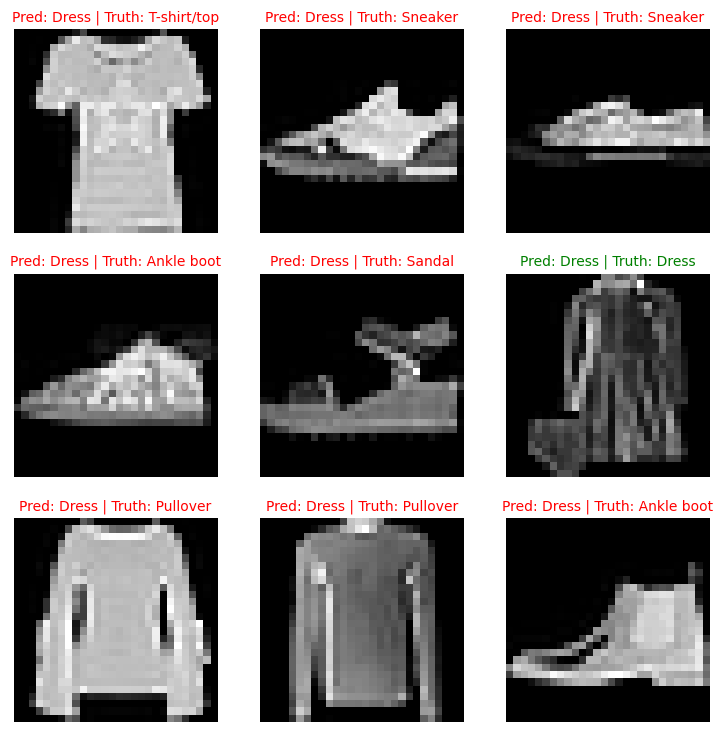

In [8]:
test()

In [9]:
results = evalModel(model=model, data_loader=testData, loss_fn=lossFunc, accuracyfn=accuracy)
results

{'model_name': 'Network',
 'model_loss': 2.305751085281372,
 'model_acc': 0.0999599358974359}

In [ ]:
train(80)

Training module Network for 80 epochs...
Epoch 0 || Avg loss per batch: 0.6023488640785217 || Training accuracy: 77.3483% ||Test accuracy: 79.4271%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 1 || Avg loss per batch: 0.41969019174575806 || Training accuracy: 84.6529% ||Test accuracy: 83.4777%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 2 || Avg loss per batch: 0.37855422496795654 || Training accuracy: 86.0951% ||Test accuracy: 85.1434%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 3 || Avg loss per batch: 0.3521992266178131 || Training accuracy: 86.9993% ||Test accuracy: 85.5293%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 4 || Avg loss per batch: 0.33327633142471313 || Training accuracy: 87.7047% ||Test accuracy: 87.0129%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 5 || Avg loss per batch: 0.317088782787323 || Training accuracy: 88.2001% ||Test accuracy: 86.8274%
Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 6 || Avg 

In [ ]:
accuracy(torch.tensor([2, 2, 3, 4]), torch.tensor([2, 2, 3, 3]))
